In [3]:
import sys
import os
import glob
import collections
import shutil
import subprocess

import numpy as np
import pandas as pd

from openeye import oechem

from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

%config IPCompleter.greedy=True

In [4]:
CWD = os.getcwd()

In [5]:
try:
    from pfabnet import base
except ModuleNotFoundError as e:
    os.chdir(os.getcwd() + os.sep + '..')
    
from pfabnet import base

In [6]:
from pfabnet.base import ENTITY_KEY, VISCOSITY_KEY

In [7]:
with open('pfabnet/sbatch_tmpl.sh', 'r') as fptr:
    sbatch_tmpl = fptr.read()
    
print(sbatch_tmpl)

#!/bin/bash -l
#SBATCH -e %j.err
#SBATCH -o %j.out
#SBATCH --nodes=1
#SBATCH --gres=gpu:v100:1
#SBATCH --mem=32gb
#SBATCH --wait



## Training

In [8]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --esp_dir $8 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train.sh', 'w') as fptr:
    fptr.write(sbatch_script)

In [592]:
!mkdir -p models
!mkdir -p models/pdgf38
!mkdir -p models/ab21
!mkdir -p models/loocv

In [10]:
# prepare dataset for LOOCV training
df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_ab21 = pd.read_csv('data/Ab21.csv')

LOOCV_MODELS_DIR = 'models/loocv'
for i, row in df_ab21.iterrows():
    df_test = df_ab21.loc[i:i]
    df_train1 = df_ab21.loc[0:i-1]
    df_train2 = df_ab21.loc[i+1:]
    
    entity = row[ENTITY_KEY]
    df_train = pd.concat([df_pdgf38, df_train1, df_train2])
    df_train.reset_index(drop=True, inplace=True)
    
    dirname = os.path.join(LOOCV_MODELS_DIR, entity)
    os.makedirs(dirname, exist_ok=True)
    
    df_train.to_csv(os.path.join(dirname, 'train.csv'), index=False)
    df_test.to_csv(os.path.join(dirname, 'test.csv'), index=False)
                   

In [12]:
NX = 10
GRID_DIM = 96
GRID_SPACING = 0.75
ESP_DIR = 'data/hm/esp'
with open('train_multi.sh', 'w') as fptr:
    fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
               ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/pdgf38', NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
               ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/ab21', NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        model_output_dir = os.path.join(LOOCV_MODELS_DIR, entity)
        training_data_file = os.path.join(model_output_dir, 'train.csv')
        fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
           (training_data_file, 'data/hm', 'PfAbNet-LOOCV', model_output_dir, NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    
    fptr.write('wait\n')
    
!chmod u+rwx train_multi.sh

## Inference

In [2414]:
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=predict\n\n'
sbatch_script += 'python pfabnet/predict.py --structure_file $1 '
sbatch_script += '--PfAbNet_model_dir $2 --PfAbNet_model_prefix $3 '
sbatch_script += '--output_file $4 --esp_dir $5 --NX $6 --grid_dim $7 --grid_spacing $8 --shell_width $9\n'

with open('sbatch_predict.sh', 'w') as fptr:
    fptr.write(sbatch_script)

In [2419]:
ESP_DIR = 'data/hm/esp'
NX = 10
GRID_DIM = 96
GRID_SPACING = 0.75
SHELL_WIDTH = 2.0
with open('predict_multi.sh', 'w') as fptr:
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/pdgf38'
        model_prefix = 'PfAbNet-PDGF38'
        output_file = 'models/pdgf38/%s.csv' % entity
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
    
    
    for row_idx, row in df_pdgf38.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/ab21'
        model_prefix = 'PfAbNet-Ab21'
        output_file = 'models/ab21/%s.csv' % entity
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))   
    
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/loocv/%s' % entity
        model_prefix = 'PfAbNet-LOOCV'
        output_file = 'models/loocv/%s/%s.csv' % (entity, entity)
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
    
    fptr.write('wait\n')
    
!chmod u+rwx predict_multi.sh
#!./predict_multi.sh

In [18]:
SCM_SCORE_KEY = 'SCM_score'
SHARMA_SCORE_KEY = 'Sharma_score'
PfAbNet_SCORE_KEY = 'VISCOSITY_PRED'

In [19]:
eisenberg_scale_hyd = collections.defaultdict(float)
eisenberg_scale_hyd['ALA'] = 0.25; eisenberg_scale_hyd['CYS'] = 0.04; eisenberg_scale_hyd['PHE'] = 0.61;
eisenberg_scale_hyd['ILE'] = 0.73; eisenberg_scale_hyd['LEU'] = 0.53; eisenberg_scale_hyd['PRO'] = -0.07;
eisenberg_scale_hyd['VAL'] = 0.54; eisenberg_scale_hyd['TRP'] = 0.37; eisenberg_scale_hyd['TYR'] = 0.02;

eisenberg_scale_philic = collections.defaultdict(float)
eisenberg_scale_philic['ASP'] = -0.72; eisenberg_scale_philic['GLU'] = -0.62; eisenberg_scale_philic['GLY'] = 0.16; 
eisenberg_scale_philic['HIS'] = -0.40; eisenberg_scale_philic['LYS'] = -1.1; eisenberg_scale_philic['MET'] = 0.26;
eisenberg_scale_philic['ASN'] = -0.64; eisenberg_scale_philic['GLN'] = -0.69; eisenberg_scale_philic['ARG'] = -1.8;
eisenberg_scale_philic['SER'] = -0.26; eisenberg_scale_philic['THR'] = -0.18; 

def get_sharma_descriptors_base(mol):
    q = 0
    hv = oechem.OEHierView(mol)
    q_chain = collections.defaultdict(float)
    qsym = 0

    HI_hyd = 0.0; HI_philic = 0.0
    chain_ids = []
    for hr in hv.GetResidues():
        res = hr.GetOEResidue()
        aa = hr.GetResidueName()
        chain_id = res.GetChainID()
        if chain_id not in chain_ids:
            chain_ids.append(chain_id)
            
        if aa in ['ARG', 'LYS']:
            q_chain[chain_id] += 1
            q += 1
        if aa in ['ASP', 'GLU']:
            q_chain[chain_id] -= 1
            q -= 1
            
        HI_hyd += eisenberg_scale_hyd[aa]
        HI_philic += eisenberg_scale_philic[aa]
        
    HI = HI_hyd / HI_philic
        
    qsym = q_chain[chain_ids[0]] * q_chain[chain_ids[1]]

    return q, qsym, HI


def get_sharma_descriptors(file_pattern):
    mol2_files = glob.glob(file_pattern)
    data = []
    for f in mol2_files:
        ifs = oechem.oemolistream(f)
        mol = oechem.OEGraphMol()
        oechem.OEReadMolecule(ifs, mol)
        ifs.close()
        
        oechem.OEPerceiveResidues(mol)
        try:
            q, qsym, HI = get_sharma_descriptors_base(mol)
            mol_id = os.path.basename(f).split('.')[0]
            data.append((mol_id, q, qsym, HI))
        except Exception as e:
            pass
        
    df = pd.DataFrame(data, columns=[ENTITY_KEY, 'q', 'qsym', 'HI'])
    
    return df


def calc_sharma_score(df_train, df_test):
    y_train = df_train[VISCOSITY_KEY].values
    X_train = df_train[['q', 'qsym', 'HI']].values   
    
    X_test = df_test[['q', 'qsym', 'HI']].values
    
    reg = LinearRegression().fit(X_train, np.log10(y_train))
    ypred = np.power(10, reg.predict(X_test))

    df_test.insert(len(df_test.columns), SHARMA_SCORE_KEY, ypred)
    
    return df_test
    

## Plot performance

In [20]:
def retrieve_prediction_outputs(file_pattern):
    pred_files = glob.glob(file_pattern)
    df_list = []
    for pred_file in pred_files:
        df = pd.read_csv(pred_file)
        df_list.append(df)

    df = pd.concat(df_list)

    return df

In [21]:
FONT_SIZE = 18

def calc_auc(y_mes, y_pred, class_threshold=20):
    y_binary = np.copy(y_mes)
    y_binary[y_binary<=class_threshold] = 0; y_binary[y_binary>class_threshold] = 1
    auc = roc_auc_score(y_binary, y_pred)  
    
    return auc, y_binary
    
def generate_parity_plot(ax, x, y, label):
    ax.scatter(x, y)
    rho = stats.spearmanr(x, y).correlation
    ax.text(0.07, 0.85, r'$\rho=%.2f$'%rho, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.set_xlabel('Measured (cP)', fontsize=FONT_SIZE)
    ax.set_ylabel('Prediction (cP)', fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)


def generate_roc_plot(ax, y_mes, y_pred, label, class_threshold=20):
    auc, y_binary = calc_auc(y_mes, y_pred, class_threshold)
    fpr, tpr, _ = roc_curve(y_binary, y_pred)
    ax.plot(fpr, tpr)
    ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
    ax.set_xlabel('False positive rate', fontsize=FONT_SIZE)
    ax.set_ylabel('True positive rate', fontsize=FONT_SIZE)
    ax.text(0.07, 0.9, 'AUC=%.2f'%auc, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    

YLIM_LOW = 0.4


def bar_plot(ax, y, yerr, tick_labels, label):
    x = np.arange(len(y))
    ax.bar(x, y, yerr=yerr, 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylim([YLIM_LOW, 1.0])
    ax.set_xticks(x)
    ax.set_ylabel('ROC-AUC', fontsize=FONT_SIZE)
    ax.set_xticklabels(tick_labels, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    

BAR_XTICK_LABELS = ['Sharma', 'SCM', 'PfAbNet']

def plot_auc(ax, df, label):
    def cal_stderror_auc(y, ypred):
        auc = []
        for i in range(500):
            y1, ypred1 = resample(y, ypred)
            try:
                auc1, _ = calc_auc(y1, ypred1)
                auc.append(auc1)
            except Exception as e:
                pass

        auc = np.array(auc)
        se = 1.96*np.std(auc)/np.sqrt(len(y))

        return se

    auc_pfabnet, _ = calc_auc(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    se_pfabnet = cal_stderror_auc(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    
    auc_sharma, _ = calc_auc(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    se_sharma = cal_stderror_auc(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    
    auc_scm, _ = calc_auc(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    se_scm = cal_stderror_auc(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    print('AUC: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (auc_pfabnet, auc_sharma, auc_scm))
    print('AUC SE: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (se_pfabnet, se_sharma, se_scm))
    
    bar_plot(ax, [auc_sharma, auc_scm, auc_pfabnet], 
             [se_sharma, se_scm, se_pfabnet], BAR_XTICK_LABELS, label)
    

def plot_spearmann_corr(ax, df, label):
    def cal_stderror_spearmanr(y, ypred):
        r = []
        for i in range(500):
            y1, ypred1 = resample(y, ypred)
            r.append(stats.spearmanr(y1, ypred1).correlation)

        r = np.array(r)
        se = 1.96*np.std(r)/np.sqrt(len(y))

        return se

    rho_pfabnet = stats.spearmanr(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY]).correlation
    se_pfabnet = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    
    rho_sharma = stats.spearmanr(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY]).correlation
    se_sharma = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    
    rho_scm = stats.spearmanr(df[VISCOSITY_KEY], df[SCM_SCORE_KEY]).correlation
    se_scm = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    
    print('Spearmann R: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (rho_pfabnet, rho_sharma, rho_scm))
    print('Spearmann SE: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (se_pfabnet, se_sharma, se_scm))

    bar_plot(ax, [rho_sharma, rho_scm, rho_pfabnet], 
             [se_sharma, se_scm, se_pfabnet], BAR_XTICK_LABELS, label)


In [22]:
df_sharma_desc = get_sharma_descriptors('data/hm/*.pdb')

In [23]:
df_pred = retrieve_prediction_outputs('models/pdgf38//*.csv')
df_ab21_pred = df_ab21.merge(df_pred, on=ENTITY_KEY)
df_ab21_pred[SCM_SCORE_KEY] = df_ab21_pred['SCM Fv']
df_ab21_pred = df_ab21_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_pred = retrieve_prediction_outputs('models/ab21//*.csv')
df_pdgf38_pred = df_pdgf38.merge(df_pred, on=ENTITY_KEY)
df_pdgf38_pred.loc[df_pdgf38_pred[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
df_pdgf38_pred[SCM_SCORE_KEY] = -df_pdgf38_pred['SCM']
df_pdgf38_pred = df_pdgf38_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_ab21_pred = calc_sharma_score(df_pdgf38_pred, df_ab21_pred)
df_pdgf38_pred = calc_sharma_score(df_ab21_pred, df_pdgf38_pred)

In [24]:
df_loocv_train = pd.concat([df_pdgf38_pred, df_ab21_pred])
df_loocv_train.drop(VISCOSITY_PRED, inplace=True, axis=1)

df_pred = retrieve_prediction_outputs('models/loocv/*/mAb*.csv')
df_loocv_pred = df_ab21.merge(df_pred, on=ENTITY_KEY)
df_loocv_pred[SCM_SCORE_KEY] = df_loocv_pred['SCM Fv']
df_loocv_pred = df_loocv_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_loocv_preds = []
for entity in df_loocv_pred[ENTITY_KEY].values:
    df_train = df_loocv_train.loc[~(df_loocv_train[ENTITY_KEY] == entity), :]
    df_test = df_loocv_pred.loc[df_loocv_pred[ENTITY_KEY] == entity, :]
    df_loocv_pred2 = calc_sharma_score(df_train, df_test)
    df_loocv_preds.append(df_loocv_pred2)
    
df_loocv_pred = pd.concat(df_loocv_preds)

Spearmann R: PfAbNet: 0.80, Sharma: 0.67, SCM: 0.75
Spearmann SE: PfAbNet: 0.02, Sharma: 0.02, SCM: 0.02
AUC: PfAbNet: 0.84, Sharma: 0.73, SCM: 0.80
AUC SE: PfAbNet: 0.02, Sharma: 0.03, SCM: 0.03
Spearmann R: PfAbNet: 0.75, Sharma: 0.65, SCM: 0.49
Spearmann SE: PfAbNet: 0.06, Sharma: 0.07, SCM: 0.07
AUC: PfAbNet: 0.82, Sharma: 0.78, SCM: 0.63
AUC SE: PfAbNet: 0.04, Sharma: 0.06, SCM: 0.06
Spearmann R: PfAbNet: 0.71, Sharma: 0.55, SCM: 0.49
Spearmann SE: PfAbNet: 0.06, Sharma: 0.07, SCM: 0.08
AUC: PfAbNet: 0.82, Sharma: 0.74, SCM: 0.63
AUC SE: PfAbNet: 0.04, Sharma: 0.06, SCM: 0.06


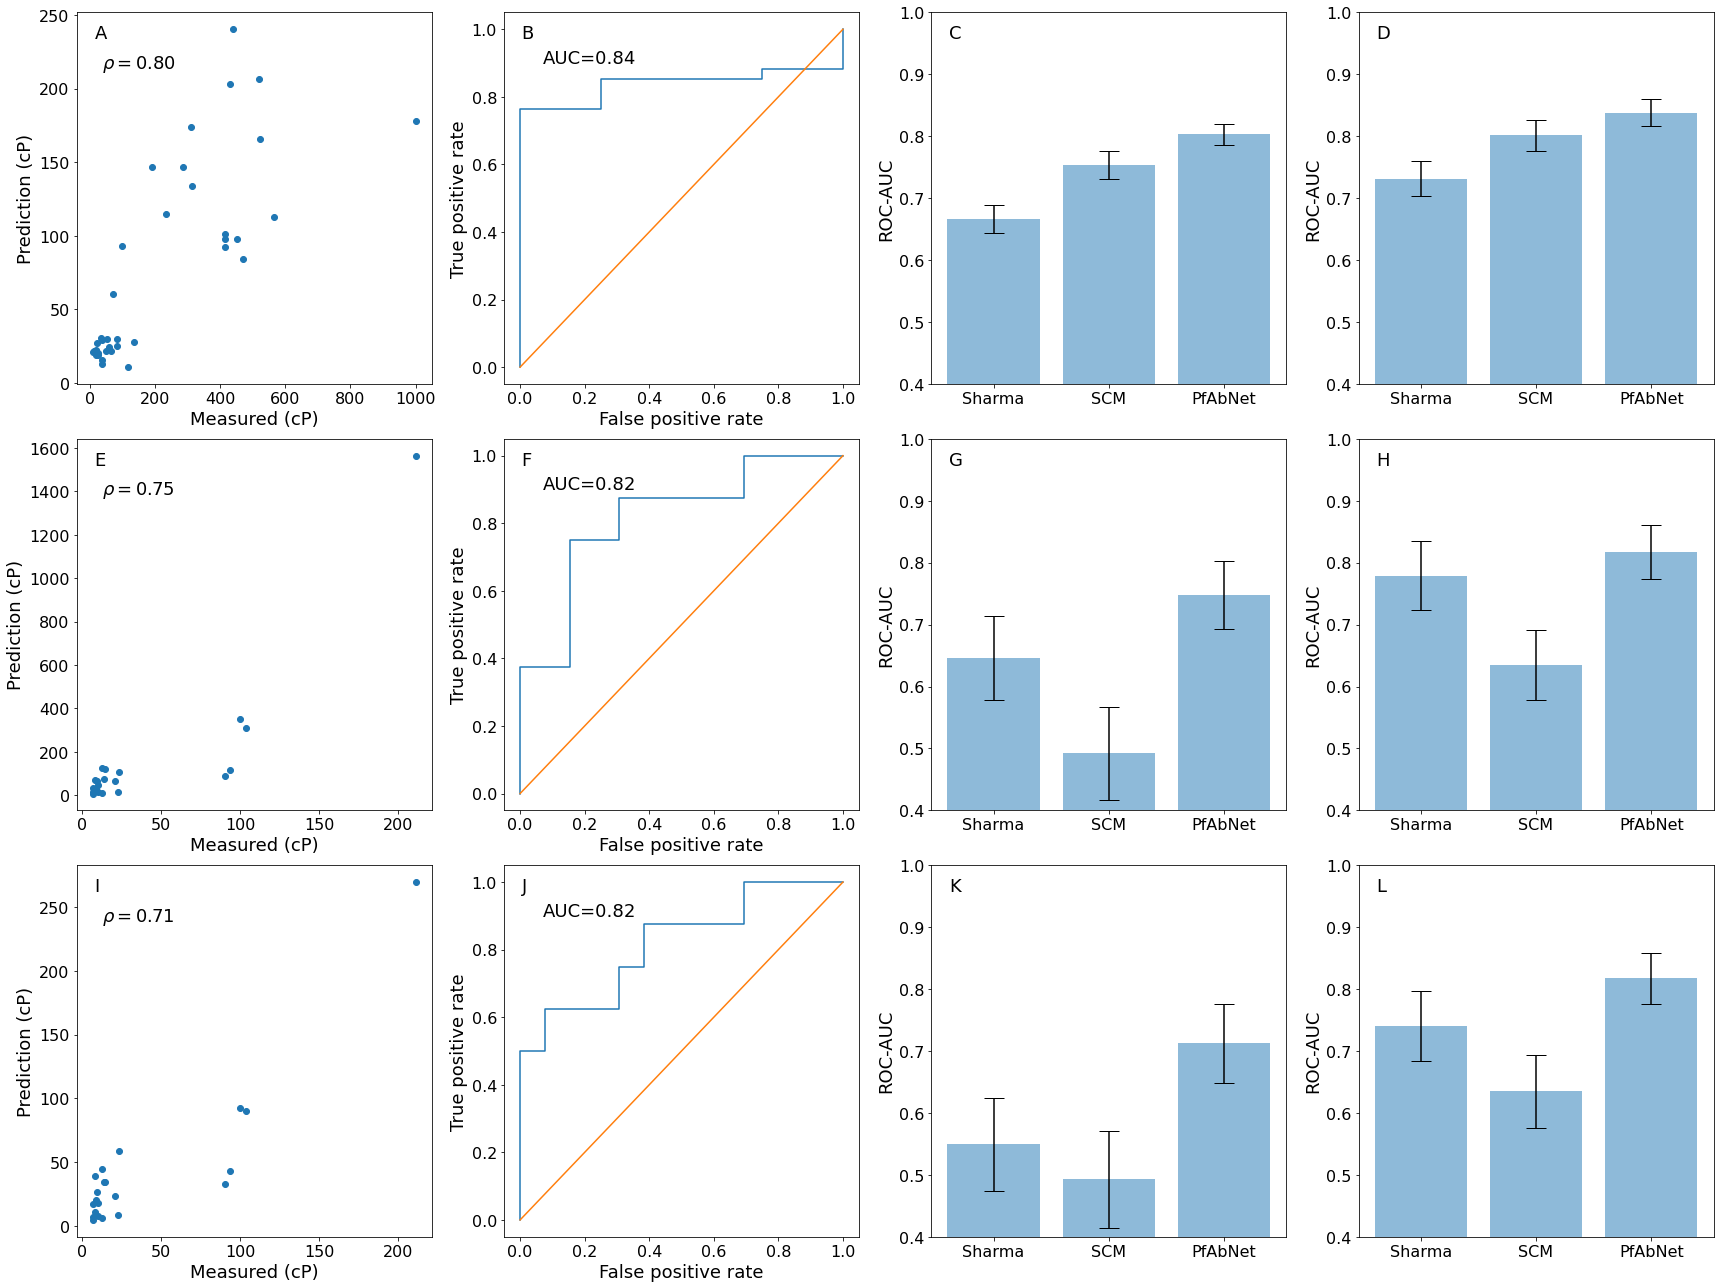

In [25]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols,6*nrows))

VISCOSITY_MES = 'Viscosity_at_150'
VISCOSITY_PRED = 'VISCOSITY_PRED'
generate_parity_plot(axs[0,0], df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[VISCOSITY_PRED], 'A')
generate_roc_plot(axs[0,1], df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[VISCOSITY_PRED], 'B')
plot_spearmann_corr(axs[0,2], df_pdgf38_pred, 'C')
plot_auc(axs[0,3], df_pdgf38_pred, 'D')

generate_parity_plot(axs[1,0], df_ab21_pred[VISCOSITY_MES], df_ab21_pred[VISCOSITY_PRED], 'E')
generate_roc_plot(axs[1,1], df_ab21_pred[VISCOSITY_MES], df_ab21_pred[VISCOSITY_PRED], 'F')
plot_spearmann_corr(axs[1,2], df_ab21_pred, 'G')
plot_auc(axs[1,3], df_ab21_pred, 'H')

generate_parity_plot(axs[2,0], df_loocv_pred[VISCOSITY_MES], df_loocv_pred[VISCOSITY_PRED], 'I')
generate_roc_plot(axs[2,1], df_loocv_pred[VISCOSITY_MES], df_loocv_pred[VISCOSITY_PRED], 'J')
plot_spearmann_corr(axs[2,2], df_loocv_pred, 'K')
plot_auc(axs[2,3], df_loocv_pred, 'L')

plt.tight_layout()